In [6]:
import pandas as pd
import numpy as np
import os
import json
import re
import string
import pickle
from nltk.chunk import ne_chunk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
# gensim
from gensim import corpora, models, similarities, matutils
import scipy.sparse
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()

In [8]:
with open('trail_agg_df.pickle', 'rb') as read_file:
    trail_agg_df = pickle.load(read_file)

In [9]:
with open('user_agg_df', 'rb') as read_file:
    user_agg_df = pickle.load(read_file)

In [10]:
not_null_df = user_agg_df[user_agg_df['review'].notnull()]

In [11]:
not_null_df['review_length'] = not_null_df['review'].str.len()

/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
smaller_df = not_null_df.copy() 
mask = (smaller_df['review_length'] > 4)
reviews_df = smaller_df.loc[mask]

In [13]:
reviews_df.head()

,username,rating,review,trail_name,review_length
1,Gabe Flores,5,"This is a very pleasant little hike, more beau...",Tin Mine Canyon Trail,311
2,Steve Blakeney,4,Fun and scenic trail with little rock pagodas ...,Tin Mine Canyon Trail,163
3,Nathan Koeneman,3,didn't make it all the way as the rain washed ...,Tin Mine Canyon Trail,74
4,Sarah Huntington,5,This trail was absolutely beautiful. The trail...,Tin Mine Canyon Trail,291
5,Louis Davis,5,Good hike today. Many parts of the trail have ...,Tin Mine Canyon Trail,595


In [14]:
# creates joined list of all reviews (by a trail)
trail_dict = {}
def pull_all_reviews(trail_name, df):
    one_trail = df[df['trail_name'] == trail_name]
    trail_review_list = one_trail['review'].tolist()
    trail_reviews = ' '.join(trail_review_list)
    return trail_reviews

In [15]:
trails = reviews_df['trail_name'].unique()

In [16]:
# created dictionary with trail and all reviews as value
for trail in trails:
    trail_reviews = pull_all_reviews(trail, reviews_df)
    trail_dict[trail] = trail_reviews

In [17]:
pd.set_option('max_colwidth',150)
# changes index to trail names
trail_df = pd.DataFrame.from_dict(trail_dict, orient='index')
trail_df.columns = ['reviews']
trail_df = trail_df.sort_index()
trail_df

,reviews
San Clemente State Beach,Great walk by the beach. Brought our dog and she loved it. Trail was temporarily closed off towards the end but a great place to spend the afterno...
Sostomo and Deer Valley Loop Trail,"Amazing trail, not hard at all, had to park on pch which is totally fine; extra mile to warm up and cool down. Make sure you have a hat and water..."
Abalone Cove Trail,A bunch of parts were closed but still a neat hike! Wear some good shoes with good traction. Six year olds enjoyed the hermit crabs. Steep walk ...
Abeja Loop Trail,Very washed out trail steep and lots of loose rocks Great trail for a quick workout and a fun way to break a sweat. Saw a rattle snake on my way d...
Ahwingna and Native Oak Loop Trail,"Did this hike on a Saturday morning & had no problem with crowds. Passed a few hikers & several bikers, but most were courteous and respectful. G..."
...,...
Wrights Lake to Grouse Lake,Love this hike. Difficult if you arent in the best of shape. Lots of up hill but so worth it. I was hiking to Twin Lakes but I missed the turn whi...
Zabriskie Point,"Nice view, nice for sunrise or nightscape too. 360 views. A lot of hiking trails off the main path. Easy to access. For pictures and information ..."
Zanja Peak Trail,This is definitely not a moderate hike. Steep inclines but we’ll worth the climb. Nice trail. It was much harder than expected but the views we...
Zumwalt Meadow And Roaring River Falls,We actually started this hike from the back country parking lot after hiking Mist Falls in the morning. This added a little over a mile round tri...


## Remove Punctuation

In [18]:
# clean function
def clean_function(review_string):
    review_string = re.sub('\[.*?\]', '', review_string)
    review_string = re.sub('[%s]' % re.escape(string.punctuation), '', review_string)
    review_string = re.sub('\w*\d\w*', '', review_string)
    review_string = re.sub('[‘’“”…]', '', review_string)
    review_string = re.sub('\n', ' ', review_string)
    review_string = re.sub('\r', ' ', review_string)
    review_string = review_string.lower()
    return review_string

In [19]:
clean_reviews = lambda x: clean_function(x)

In [20]:
data_clean = pd.DataFrame(trail_df.reviews.apply(clean_reviews))
data_clean

,reviews
San Clemente State Beach,great walk by the beach brought our dog and she loved it trail was temporarily closed off towards the end but a great place to spend the afternoon...
Sostomo and Deer Valley Loop Trail,amazing trail not hard at all had to park on pch which is totally fine extra mile to warm up and cool down make sure you have a hat and water eh...
Abalone Cove Trail,a bunch of parts were closed but still a neat hike wear some good shoes with good traction six year olds enjoyed the hermit crabs steep walk dow...
Abeja Loop Trail,very washed out trail steep and lots of loose rocks great trail for a quick workout and a fun way to break a sweat saw a rattle snake on my way do...
Ahwingna and Native Oak Loop Trail,did this hike on a saturday morning had no problem with crowds passed a few hikers several bikers but most were courteous and respectful great ...
...,...
Wrights Lake to Grouse Lake,love this hike difficult if you arent in the best of shape lots of up hill but so worth it i was hiking to twin lakes but i missed the turn while ...
Zabriskie Point,nice view nice for sunrise or nightscape too views a lot of hiking trails off the main path easy to access for pictures and information about th...
Zanja Peak Trail,this is definitely not a moderate hike steep inclines but well worth the climb nice trail it was much harder than expected but the views were g...
Zumwalt Meadow And Roaring River Falls,we actually started this hike from the back country parking lot after hiking mist falls in the morning this added a little over a mile round trip...


## Compound Term Extraction

In [21]:
from nltk.tokenize import MWETokenizer # multi-word expressions #trail names?

In [22]:
mwe_tokenizer = MWETokenizer([('water','fall'),('half','dome')])

## Remove Stop Words

### NLTK

In [23]:
from nltk.corpus import stopwords
# incorporate stop words when creating the count vectorizer
nltk_stopwords = stopwords.words('english')
# tokens = nltk.tokenize.word_tokenize(clean_reviews)
# tokens = [token for token in tokens if not token in nltk_stopwords]

In [24]:
customize_stop_words = [
    'trail', 'hike','great','get','go','im','way','back','beautiful','lot','trails','view','mile','water',
    'easy','nice','half_dome','good','time','top','little','так','по','как','ça','zumwalt'
]
nltk_stopwords.extend(customize_stop_words)

In [133]:
tokens2 = remove_stopwords(stopwords = nltk_stopwords,content=clean_reviews)

In [135]:
Counter(tokens2).most_common()

[('views', 18745),
 ('beautiful', 16986),
 ('nice', 13241),
 ('easy', 13211),
 ('water', 12562),
 ('top', 11161),
 ('good', 10935),
 ('time', 9886),
 ('one', 9752),
 ('miles', 8911),
 ('little', 8743),
 ('lake', 8717),
 ('day', 8488),
 ('lot', 8441),
 ('lots', 8382),
 ('would', 8220),
 ('pretty', 8125),
 ('view', 7794),
 ('parking', 7526),
 ('around', 7250),
 ('first', 7210),
 ('people', 7058),
 ('steep', 7039),
 ('trails', 6940),
 ('see', 6852),
 ('well', 6787),
 ('worth', 6745),
 ('took', 6699),
 ('definitely', 6669),
 ('really', 6579),
 ('take', 6545),
 ('hiking', 6478),
 ('going', 6352),
 ('falls', 6322),
 ('road', 6254),
 ('amazing', 6182),
 ('went', 6104),
 ('recommend', 5723),
 ('snow', 5705),
 ('like', 5686),
 ('along', 5639),
 ('much', 5598),
 ('bring', 5558),
 ('fun', 5412),
 ('loop', 5341),
 ('walk', 5243),
 ('also', 5225),
 ('mile', 5133),
 ('make', 5053),
 ('got', 5014),
 ('area', 4985),
 ('right', 4941),
 ('shade', 4891),
 ('bit', 4827),
 ('park', 4798),
 ('end', 4658),
 

## Part of Speech Tagging

In [25]:
# pulling nouns and adjectives from text
def nouns_adj(text):
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
#     return nouns_adj
    return ' '.join(nouns_adj)

In [32]:
data_na = pd.DataFrame(data_lemm.reviews.apply(nouns_adj))
data_na

,reviews
San Clemente State Beach,walk beach dog towards place afternoon view beach beach sand level surface beach ocean urban beach view home beach designer urban planning high po...
Sostomo and Deer Valley Loop Trail,hard park pch fine extra warm cool sure lot people kid walk dog lot elevation gain hill guess half interesting hill long drive home welcome la not...
Abalone Cove Trail,bunch part neat wear shoe traction year old enjoyed hermit crab steep walk rocky beach lot tidepools spot marine education dog part cliff view ama...
Abeja Loop Trail,steep lot loose rock quick workout fun break sweat rattle heard bush sun eye pretty rocky watch rattler spiderwebs youre dog arent many people abi...
Ahwingna and Native Oak Loop Trail,saturday morning problem crowd hiker several bikers courteous respectful heart youre gon much dog poop saw decent amount hiker end hr dont family ...
...,...
Wrights Lake to Grouse Lake,love difficult arent best shape lot twin lake turn granite happy accident tho lake mix dirt steep spot tough ole lady feel short skirt pool base s...
Zabriskie Point,sunrise nightscape view main path access picture information many instagram nathanvanengen small short distance form kind point different geologic...
Zanja Peak Trail,moderate steep incline worth climb much harder view rate strenuous lot uphill steep harder view moderate yikes rock yikes left straight peak right...
Zumwalt Meadow And Roaring River Falls,country mist fall morning round trip overall difficult area actual meadow section due bridge semibuggy bad mist fall afternoon stroll waterfall ov...


In [197]:
# pickle.dump(data_na, open("data_na.pkl", "wb"))

In [41]:
cvna = CountVectorizer(stop_words=nltk_stopwords, min_df = 3)
data_cvna = cvna.fit_transform(data_na.reviews)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_na.index
data_dtmna

,ab,abandon,abandoned,abbey,aber,ability,abit,able,abound,abrupt,...,zigzag,zillion,zion,zip,zombie,zone,zoo,zoom,zu,не
San Clemente State Beach,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Sostomo and Deer Valley Loop Trail,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Abalone Cove Trail,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Abeja Loop Trail,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Ahwingna and Native Oak Loop Trail,0,0,0,0,0,0,0,3,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wrights Lake to Grouse Lake,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Zabriskie Point,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zanja Peak Trail,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Zumwalt Meadow And Roaring River Falls,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [458]:
pickle.dump(corpusna, open("corpusna.pkl", "wb"))

In [34]:
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.015*"lake" + 0.014*"fall" + 0.013*"waterfall" + 0.012*"rock" + 0.010*"road" + 0.009*"area" + 0.009*"people" + 0.009*"dog" + 0.008*"creek" + 0.008*"day"'),
 (1,
  '0.017*"fall" + 0.011*"day" + 0.010*"beach" + 0.010*"canyon" + 0.008*"worth" + 0.008*"rock" + 0.007*"loop" + 0.007*"point" + 0.007*"people" + 0.006*"waterfall"'),
 (2,
  '0.015*"day" + 0.012*"summit" + 0.012*"snow" + 0.011*"peak" + 0.010*"hour" + 0.008*"lake" + 0.008*"worth" + 0.007*"steep" + 0.007*"last" + 0.007*"people"'),
 (3,
  '0.011*"steep" + 0.010*"loop" + 0.009*"dog" + 0.009*"area" + 0.009*"park" + 0.008*"day" + 0.008*"road" + 0.008*"hill" + 0.007*"people" + 0.007*"mountain"')]

In [421]:
ldana = models.LdaModel(corpus=corpusna, num_topics=5, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.023*"fall" + 0.022*"waterfall" + 0.014*"time" + 0.012*"little" + 0.009*"rock" + 0.009*"good" + 0.009*"people" + 0.009*"area" + 0.009*"road" + 0.008*"dog"'),
 (1,
  '0.029*"lake" + 0.013*"day" + 0.012*"time" + 0.011*"snow" + 0.011*"rock" + 0.008*"fall" + 0.007*"little" + 0.007*"worth" + 0.007*"top" + 0.007*"good"'),
 (2,
  '0.018*"top" + 0.017*"good" + 0.015*"steep" + 0.013*"time" + 0.010*"road" + 0.008*"little" + 0.008*"rock" + 0.007*"mountain" + 0.007*"people" + 0.007*"day"'),
 (3,
  '0.013*"good" + 0.012*"park" + 0.011*"time" + 0.011*"dog" + 0.010*"loop" + 0.010*"area" + 0.009*"little" + 0.009*"beach" + 0.008*"day" + 0.008*"walk"'),
 (4,
  '0.022*"top" + 0.014*"time" + 0.013*"peak" + 0.012*"day" + 0.012*"summit" + 0.010*"hour" + 0.008*"snow" + 0.008*"worth" + 0.008*"good" + 0.007*"last"')]

In [404]:
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=15)
ldana.print_topics()

[(0,
  '0.012*"time" + 0.011*"good" + 0.010*"area" + 0.010*"little" + 0.010*"road" + 0.009*"loop" + 0.009*"dog" + 0.008*"park" + 0.008*"day" + 0.007*"tree"'),
 (1,
  '0.019*"lake" + 0.015*"top" + 0.014*"day" + 0.013*"time" + 0.013*"snow" + 0.012*"peak" + 0.011*"summit" + 0.009*"hour" + 0.007*"good" + 0.007*"worth"'),
 (2,
  '0.018*"top" + 0.017*"fall" + 0.015*"good" + 0.014*"time" + 0.010*"steep" + 0.010*"rock" + 0.010*"waterfall" + 0.009*"people" + 0.009*"little" + 0.008*"day"')]

In [59]:
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=25)
ldana.print_topics()

[(0,
  '0.015*"rock" + 0.011*"road" + 0.010*"steep" + 0.009*"beach" + 0.008*"day" + 0.008*"canyon" + 0.008*"fun" + 0.008*"area" + 0.007*"part" + 0.007*"worth"'),
 (1,
  '0.016*"peak" + 0.013*"steep" + 0.010*"day" + 0.009*"summit" + 0.008*"road" + 0.008*"hour" + 0.007*"tree" + 0.007*"loop" + 0.007*"people" + 0.006*"part"'),
 (2,
  '0.016*"fall" + 0.015*"waterfall" + 0.013*"dog" + 0.011*"area" + 0.010*"people" + 0.008*"park" + 0.008*"place" + 0.008*"road" + 0.008*"creek" + 0.007*"day"'),
 (3,
  '0.024*"lake" + 0.016*"day" + 0.014*"snow" + 0.009*"worth" + 0.009*"hour" + 0.007*"rock" + 0.007*"fall" + 0.007*"summit" + 0.007*"people" + 0.006*"trip"')]

In [457]:
# pickle.dump(ldana, open("ldana.pkl", "wb"))

## Count Vectorizer

In [26]:
# Create a CountVectorizer for parsing/counting words
cv = CountVectorizer(stop_words=nltk_stopwords)
data_cv = cv.fit_transform(data_clean.reviews)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,aaaah,aaalll,aahing,aan,aaron,ab,abalone,abandance,abandon,abandoned,...,헤드,호출하신다,호흡이,화려한,화사한,활짝,힘겹게,힘들게,藍藍藍,量罹
San Clemente State Beach,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sostomo and Deer Valley Loop Trail,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abalone Cove Trail,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abeja Loop Trail,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ahwingna and Native Oak Loop Trail,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wrights Lake to Grouse Lake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zabriskie Point,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zanja Peak Trail,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zumwalt Meadow And Roaring River Falls,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
tdm = data_dtm.transpose()
tdm.head()

,San Clemente State Beach,Sostomo and Deer Valley Loop Trail,Abalone Cove Trail,Abeja Loop Trail,Ahwingna and Native Oak Loop Trail,Alamere Falls and Wildcat Camp via Bear Valley Trail,Alamere Falls via Coast Trail from Palomarin Trailhead,Aliso Creek and Wood Canyon Loop Trail,Aliso Summit Trail,Almaden Quicksilver County Park Mountain Bike Trail,...,Wolverton to Panther Gap to Mehrten Meadow,"Woods, Winnemucca, and Round Top Lakes",Woodson Mountain and Potato Chip Rock via Hwy 67,Wright Peak Summit Trail,Wrights Lake to Enchanted Pools,Wrights Lake to Grouse Lake,Zabriskie Point,Zanja Peak Trail,Zumwalt Meadow And Roaring River Falls,Zumwalt Meadow Loop Trail
aaaah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaalll,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aahing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaron,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [233]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [234]:
len(id2word)

36307

## Named Entity Recognition

In [ ]:
def extract_entities(text):
    entities = []
    # tokenize into sentences
    for sentence in nltk.sent_tokenize(text):
        # tokenize sentences into words
        # add part-of-speech tags
        # use NLTK's NER classifier
        chunks = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sentence)))
        # parse the results
        entities.extend([chunk for chunk in chunks if hasattr(chunk, 'label')])
    return entities

for entity in extract_entities(tokens2):
    print '[' + entity.label() + '] ' + ' '.join(c[0] for c in entity.leaves())
    
# what to do if entity is incorrect?

In [29]:
items = [i.text for i in doc.ents]
Counter(items).most_common(15)

[('half', 94),
 ('one', 72),
 ('Half', 57),
 ('first', 50),
 ('Half Dome', 49),
 ('Nevada', 43),
 ('2', 43),
 ('3', 42),
 ('4', 41),
 ('Nevada Falls', 37),
 ('the Mist Trail', 37),
 ('One', 33),
 ('Yosemite', 32),
 ('two', 28),
 ('the day', 27)]

## Stemming

In [137]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

'charg'

In [139]:
# stem the tokens
stemmed_tokens = [stemmer.stem(t) for t in tokens2]

[('view', 26645),
 ('beauti', 17576),
 ('lot', 16823),
 ('mile', 14044),
 ('nice', 13454),
 ('park', 13331),
 ('easi', 13216),
 ('time', 12794),
 ('water', 12717),
 ('hike', 12633),
 ('top', 11263),
 ('good', 10992),
 ('lake', 10670),
 ('one', 10231),
 ('day', 9714),
 ('start', 9679),
 ('take', 8848),
 ('littl', 8757),
 ('walk', 8291),
 ('would', 8220),
 ('pretti', 8127),
 ('fall', 7974),
 ('rock', 7589),
 ('see', 7427),
 ('around', 7255)]

In [140]:
# count the stemmed tokens
c = Counter(stemmed_tokens)
c.most_common(25)       # all lowercase

[('view', 26645),
 ('beauti', 17576),
 ('lot', 16823),
 ('mile', 14044),
 ('nice', 13454),
 ('park', 13331),
 ('easi', 13216),
 ('time', 12794),
 ('water', 12717),
 ('hike', 12633),
 ('top', 11263),
 ('good', 10992),
 ('lake', 10670),
 ('one', 10231),
 ('day', 9714),
 ('start', 9679),
 ('take', 8848),
 ('littl', 8757),
 ('walk', 8291),
 ('would', 8220),
 ('pretti', 8127),
 ('fall', 7974),
 ('rock', 7589),
 ('see', 7427),
 ('around', 7255)]

## Lemmatization

In [28]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [29]:
# removes stopwords, compound word extraction, and lemmatization
def stop_lem(string):
#     tokens = nltk.tokenize.word_tokenize(string)
    tokens = mwe_tokenizer.tokenize(word_tokenize(string))
    tokens = [token for token in tokens if not token in nltk_stopwords]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)
#     return tokens

In [30]:
lemmed_reviews = lambda x: stop_lem(x)

In [31]:
data_lemm = pd.DataFrame(data_clean.reviews.apply(lemmed_reviews))
data_lemm

,reviews
San Clemente State Beach,walk beach brought dog loved temporarily closed towards end place spend afternoon amazing view walking beach beach sand getting washed level surfa...
Sostomo and Deer Valley Loop Trail,amazing hard park pch totally fine extra warm cool make sure hat eh lot people first bring kid walk dog take lot elevation gain hill wayi guess ha...
Abalone Cove Trail,bunch part closed still neat wear shoe traction six year old enjoyed hermit crab steep walk secluded rocky beach lot tidepools roundtrip spot mari...
Abeja Loop Trail,washed steep lot loose rock quick workout fun break sweat saw rattle snake heard bush sun set keep eye peeled headphone pretty rocky watch rattler...
Ahwingna and Native Oak Loop Trail,saturday morning problem crowd passed hiker several bikers courteous respectful heart pumping without feeling like youre gon na die much dog poop ...
...,...
Wrights Lake to Grouse Lake,love difficult arent best shape lot hill worth hiking twin lake missed turn gawking granite happy accident tho grouse lake mix dirt rock fairly st...
Zabriskie Point,sunrise nightscape view hiking main path access picture information many follow instagram nathanvanengen small short distance form parking icing k...
Zanja Peak Trail,definitely moderate steep incline well worth climb much harder expected view would rate strenuous lot uphill steep climbing harder expected view w...
Zumwalt Meadow And Roaring River Falls,actually started country parking hiking mist fall morning added round trip overall difficult exposed area much shade actual meadow section closed ...


In [57]:
# removes stopwords, compound word extraction, and lemmatization
# def spacy_lem(string):
#     doc = spacy_nlp(string)
#     tokens = [token.text for token in doc]
#     tokens = [t.lemma_ for t in tokens]
#     return ' '.join(tokens)

In [58]:
# spacy_lemm_reviews = lambda x: spacy_lem(x)

In [ ]:
# spacy_lemm = pd.DataFrame(data_clean.reviews.apply(spacy_lemm_reviews))
# spacy_lemm

## Topic Modeling

### LDA & CV

In [37]:
cvlemm = CountVectorizer(stop_words=nltk_stopwords, min_df = 3)
data_cvlemm = cvlemm.fit_transform(data_lemm.reviews)
data_dtmlemm = pd.DataFrame(data_cvlemm.toarray(), columns=cvlemm.get_feature_names())
data_dtmlemm.index = data_lemm.index
data_dtmlemm

,ab,abalone,abandon,abandoned,abbey,abd,aber,ability,abit,able,...,zipped,zipping,zombie,zone,zoo,zoom,zoomed,zooming,zu,не
San Clemente State Beach,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Sostomo and Deer Valley Loop Trail,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
Abalone Cove Trail,0,4,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
Abeja Loop Trail,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Ahwingna and Native Oak Loop Trail,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wrights Lake to Grouse Lake,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Zabriskie Point,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zanja Peak Trail,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Zumwalt Meadow And Roaring River Falls,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Create the gensim corpus
corpuslemm = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmlemm.transpose()))

# Create the vocabulary dictionary
id2wordlemm = dict((v, k) for k, v in cvlemm.vocabulary_.items())

In [316]:
ldalemm = models.LdaModel(corpus=corpuslemm, num_topics=5, id2word=id2wordlemm, passes=8)
ldalemm.print_topics()

[(0,
  '0.011*"good" + 0.008*"top" + 0.008*"time" + 0.007*"parking" + 0.007*"dog" + 0.007*"steep" + 0.006*"one" + 0.006*"loop" + 0.006*"pretty" + 0.006*"take"'),
 (1,
  '0.015*"top" + 0.009*"peak" + 0.009*"summit" + 0.009*"time" + 0.008*"day" + 0.007*"snow" + 0.007*"one" + 0.006*"hour" + 0.006*"took" + 0.006*"steep"'),
 (2,
  '0.031*"lake" + 0.009*"day" + 0.008*"snow" + 0.007*"one" + 0.007*"time" + 0.007*"tree" + 0.006*"creek" + 0.006*"around" + 0.006*"first" + 0.005*"would"'),
 (3,
  '0.018*"fall" + 0.013*"waterfall" + 0.009*"time" + 0.007*"little" + 0.007*"one" + 0.006*"good" + 0.006*"people" + 0.006*"pretty" + 0.006*"would" + 0.006*"road"'),
 (4,
  '0.016*"rock" + 0.009*"time" + 0.007*"lake" + 0.007*"little" + 0.007*"good" + 0.006*"one" + 0.006*"pretty" + 0.006*"would" + 0.006*"day" + 0.006*"area"')]

In [317]:
ldalemm = models.LdaModel(corpus=corpuslemm, num_topics=4, id2word=id2wordlemm, passes=8)
ldalemm.print_topics()

[(0,
  '0.009*"good" + 0.008*"dog" + 0.008*"time" + 0.007*"little" + 0.007*"loop" + 0.007*"parking" + 0.007*"area" + 0.006*"one" + 0.006*"pretty" + 0.006*"waterfall"'),
 (1,
  '0.014*"top" + 0.009*"time" + 0.009*"fall" + 0.007*"peak" + 0.007*"day" + 0.007*"one" + 0.007*"worth" + 0.006*"summit" + 0.006*"rock" + 0.006*"hour"'),
 (2,
  '0.026*"lake" + 0.008*"time" + 0.008*"day" + 0.008*"snow" + 0.007*"one" + 0.006*"around" + 0.006*"little" + 0.006*"road" + 0.006*"would" + 0.005*"good"'),
 (3,
  '0.009*"good" + 0.009*"time" + 0.008*"top" + 0.008*"steep" + 0.007*"parking" + 0.007*"walk" + 0.006*"beach" + 0.006*"one" + 0.006*"take" + 0.006*"day"')]

In [ ]:
ldalemm = models.LdaModel(corpus=corpuslemm, num_topics=5, id2word=id2wordlemm, passes=20)
ldalemm.print_topics()

In [ ]:
# topic 0: water fall, waterfall, day, worth
# topic 1: easy, crowded hikes with dogs
# topic 2: steep, peak day hike
# topic 3: summit lake (alpine lake) hike

In [47]:
from sklearn.decomposition import LatentDirichletAllocation

lda_cv = LatentDirichletAllocation(n_components=4,max_iter=20)
doc_topic_lda_cv = lda_cv.fit_transform(data_cvna)

### LSA & CV

In [319]:
from sklearn.decomposition import TruncatedSVD

In [54]:
lsa = TruncatedSVD(4)
doc_topic = lsa.fit_transform(data_cvna)
lsa.explained_variance_ratio_

array([0.33696045, 0.09230277, 0.06116264, 0.04926537])

In [55]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = cvna.get_feature_names())
topic_word

,ab,abandon,abandoned,abbey,aber,ability,abit,able,abound,abrupt,...,zone,zoo,zoom,zu,zumwalt,ça,как,не,по,так
component_1,0.0,0.0,0.0,0.0,0.0,0.003,0.0,0.040,0.0,0.0,...,0.002,0.001,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
component_2,-0.0,0.0,-0.0,0.0,-0.0,-0.001,-0.0,0.000,0.0,-0.0,...,0.004,-0.001,-0.0,-0.0,-0.0,-0.000,-0.0,-0.0,-0.0,-0.0
component_3,-0.0,-0.0,-0.0,-0.0,0.0,0.002,-0.0,0.020,-0.0,-0.0,...,0.001,-0.001,-0.0,0.0,0.0,0.001,0.0,-0.0,-0.0,0.0
component_4,0.0,0.0,0.0,-0.0,-0.0,-0.001,0.0,-0.005,-0.0,-0.0,...,0.000,0.001,0.0,-0.0,-0.0,-0.000,-0.0,-0.0,-0.0,-0.0


In [47]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [56]:
display_topics(lsa, cvna.get_feature_names(), 5)


Topic  0
day, fall, people, hour, summit

Topic  1
summit, day, snow, camp, lake

Topic  2
cable, fall, permit, mist, dome

Topic  3
backbone, summit, ski, baldy, peak


### NMF

In [2]:
from sklearn.decomposition import NMF

In [43]:
nmf_model = NMF(6)
doc_topic = nmf_model.fit_transform(data_cvna)

In [49]:
topic_word = pd.DataFrame(nmf_model.components_.round(4),
             index = ["component_1","component_2","component_3","component_4","component_5","component_6"],
             columns = cvna.get_feature_names())
topic_word

,ab,abandon,abandoned,abbey,aber,ability,abit,able,abound,abrupt,...,zigzag,zillion,zion,zip,zombie,zone,zoo,zoom,zu,не
component_1,0.0090,0.0039,0.0031,0.0032,0.0000,0.0780,0.0113,1.4354,0.0073,0.0011,...,0.0245,0.0006,0.1793,0.0000,0.0000,0.0108,0.0862,0.0167,0.0000,0.0009
component_2,0.0000,0.0004,0.0000,0.0000,0.0046,0.0280,0.0000,1.0318,0.0012,0.0000,...,0.0044,0.0000,0.1017,0.0012,0.0293,0.2129,0.0000,0.0000,0.0049,0.0000
component_3,0.0003,0.0000,0.0000,0.0002,0.0068,0.1151,0.0000,1.2389,0.0009,0.0000,...,0.0073,0.0270,0.0141,0.0303,0.0006,0.0247,0.0000,0.0000,0.0088,0.0000
component_4,0.0000,0.0000,0.0000,0.0031,0.0000,0.0547,0.0000,0.4590,0.0164,0.0035,...,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0011,0.0029
component_5,0.0000,0.0000,0.0000,0.0000,0.0251,0.0941,0.0000,1.0818,0.0001,0.0064,...,0.0224,0.0000,0.1819,0.0096,0.0000,0.0172,0.0168,0.0063,0.0289,0.0031
component_6,0.0003,0.0058,0.0000,0.0001,0.0019,0.0676,0.0022,0.4695,0.0027,0.0000,...,0.0015,0.0000,0.0000,0.0110,0.0000,0.0000,0.0000,0.0010,0.0017,0.0000


In [48]:
display_topics(nmf_model, cvna.get_feature_names(), 10)


Topic  0
rock, road, area, steep, dog, people, fun, peak, loop, park

Topic  1
day, summit, camp, hour, snow, switchbacks, whitney, peak, portal, ice

Topic  2
cable, day, people, fall, hour, permit, worth, mist, dome, dont

Topic  3
lake, snow, day, worth, rock, trip, hour, first, people, dog

Topic  4
fall, waterfall, worth, people, rock, day, area, creek, dog, end

Topic  5
backbone, ski, summit, baldy, devil, hut, steep, bowl, peak, snow


In [63]:
H = pd.DataFrame(doc_topic.round(5),
             index = data_dtmna.index,
             columns = ["component_1","component_2","component_3","component_4" ])
H

,component_1,component_2,component_3,component_4
San Clemente State Beach,4.03337,-2.12374,-1.89458,0.17585
Sostomo and Deer Valley Loop Trail,31.64801,-12.14313,-7.32155,5.87951
Abalone Cove Trail,34.09771,-12.23676,-8.38296,-0.05208
Abeja Loop Trail,22.28339,-4.45430,-7.27953,3.53734
Ahwingna and Native Oak Loop Trail,56.84231,-14.62664,-14.32442,8.60128
...,...,...,...,...
Wrights Lake to Grouse Lake,22.09980,3.14473,-9.27655,-20.03357
Zabriskie Point,19.62334,-5.81048,-2.57777,1.90683
Zanja Peak Trail,33.00204,-3.52678,-9.77014,9.65633
Zumwalt Meadow And Roaring River Falls,22.89846,-12.31775,-2.41327,0.02845


### TF IDF & LSA

In [33]:
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
vectorizer = TfidfVectorizer(min_df=.01,max_df=0.95, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(data_na.reviews)
corpus = matutils.Sparse2Corpus(doc_term_matrix.transpose())

In [35]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=8)
doc_topic_svd = svd.fit_transform(doc_term_matrix)

In [36]:
feature_names = vectorizer.get_feature_names()
vectorizer.get_feature_names()
for i in range(8):
    component = svd.components_[i]
    features = [(ind, x) for ind, x in enumerate(component)]
    top_features = sorted(features, key=lambda x:x[1], reverse=True)[:10]
    top_words = [feature_names[x[0]] for x in top_features]
    print ("\n Topic %d: " %(i))
    print (", ".join(top_words))


 Topic 0: 
lake, dog, day, fall, lot, steep, road, waterfall, rock, mile

 Topic 1: 
lake, snow, mosquito, meadow, night, camp, granite, tahoe, trip, pas

 Topic 2: 
fall, waterfall, creek, river, pool, stream, rock, wet, camp, yosemite

 Topic 3: 
beach, lake, ocean, walk, dog, bridge, coastal, cliff, coast, bluff

 Topic 4: 
beach, peak, summit, snow, ocean, fall, rock, worth, camp, coast

 Topic 5: 
redwood, tree, creek, sequoia, meadow, forest, fern, grove, ridge, stream

 Topic 6: 
rock, river, formation, canyon, joshua, sequoia, meadow, fun, tree, boulder

 Topic 7: 
river, bridge, cow, meadow, snow, dog, summit, camp, day, walk


In [163]:
print('Explained Variance Ratio per topic:\n',svd.explained_variance_ratio_)


Explained Variance Ratio per topic:
 [0.01495059 0.0338619  0.02832045 0.01944455 0.01682159 0.01311332]


In [190]:
H = pd.DataFrame(doc_topic_svd.round(5),
             index = data_na.index,
             columns = ["topic_1","topic_2","topic_3","topic_4",
                       "topic_5","topic_6","topic_7","topic_8"])
H.head(20)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
San Clemente State Beach,0.22542,-0.13469,-0.18018,0.57451,0.28943,-0.04397,-0.04285,0.07803
Sostomo and Deer Valley Loop Trail,0.49862,-0.16102,-0.02633,0.00737,-0.04422,0.01520,-0.06261,-0.15596
Abalone Cove Trail,0.35295,-0.12496,-0.11265,0.44063,0.28590,-0.12042,0.11768,-0.01057
Abeja Loop Trail,0.51117,-0.11547,-0.17537,-0.03010,-0.06712,-0.15096,-0.06686,-0.09886
Ahwingna and Native Oak Loop Trail,0.57553,-0.17011,-0.16856,-0.04716,-0.17851,-0.08808,-0.09814,0.00027
Alamere Falls and Wildcat Camp via Bear Valley Trail,0.38639,-0.07966,0.10361,0.20753,0.26562,-0.00227,0.05958,-0.01086
Alamere Falls via Coast Trail from Palomarin Trailhead,0.53943,-0.10333,0.33691,0.35330,0.35219,-0.11105,-0.12486,-0.08011
Aliso Creek and Wood Canyon Loop Trail,0.50902,-0.15920,-0.13376,0.06699,-0.09918,-0.00838,0.07696,-0.02756
Aliso Summit Trail,0.41419,-0.13647,-0.18528,0.13056,0.08675,-0.05595,-0.03272,0.00173
Almaden Quicksilver County Park Mountain Bike Trail,0.34237,-0.09555,-0.10330,-0.02070,-0.13718,-0.01335,-0.06260,-0.01738


### KMEANS

In [160]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

result = svd.fit_transform(doc_term_matrix)
km = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1)
km.fit(result)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=6, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [161]:
ypred = km.fit_predict(result) ## WHAT TO PUT HERE??

In [153]:
km = KMeans(n_clusters=8)
ypred = km.fit_predict(result)

In [137]:
# X and Y axes of the plot using SVD decomposition
x = result[:, 0]
y = result[:, 1]

Text(0.5, 1.0, 'Segregation of Topic Clusters')

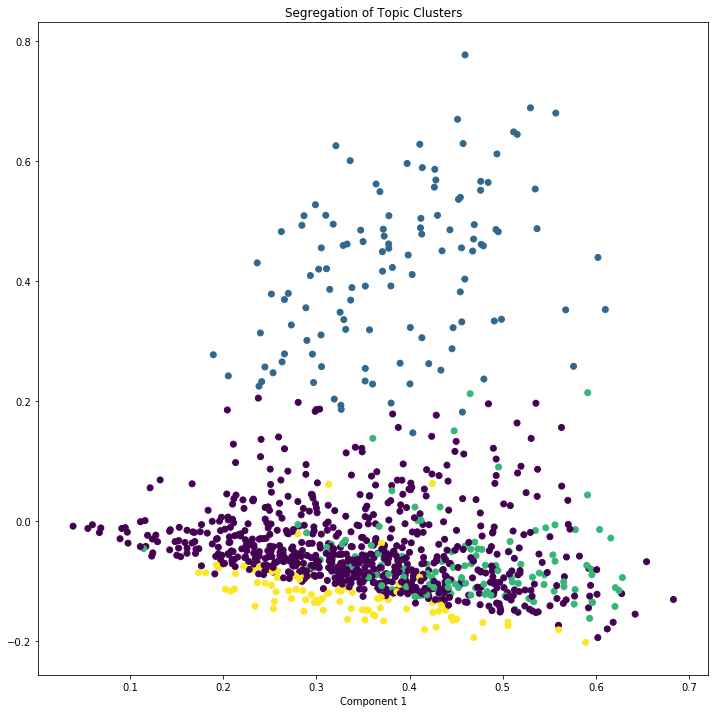

In [138]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=ypred)
plt.xlabel('Component 4')
plt.xlabel('Component 3')
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

### UMAP

In [148]:
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [151]:
ypred

array([6, 1, 6, ..., 1, 5, 4], dtype=int32)

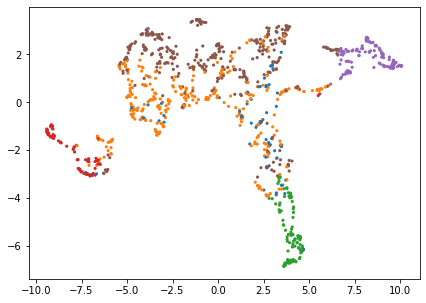

In [162]:
X_topics = svd_model.fit_transform(matrix)
embedding = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = [sns.color_palette()[x] for x in ypred],
s = 10, # size
edgecolor='none'
)
plt.show()

In [444]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
# n-1 rows each is a vector with i-1 posisitons, where n the number of documents
# i the topic number and tmp[i] = probability of topic i
topic_weights = []
for row_list in lda_model_tfidf[corpus_tfidf]:
    tmp = np.zeros(4)
    for i, w in row_list:
        tmp[i] = w
    topic_weights.append(tmp)
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1012 samples in 0.000s...
[t-SNE] Computed neighbors for 1012 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1012
[t-SNE] Computed conditional probabilities for sample 1012 / 1012
[t-SNE] Mean sigma: 0.002489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.596989
[t-SNE] KL divergence after 1000 iterations: 0.306013


Loading BokehJS ...

In [440]:
print(lda_model_tfidf.print_topics())

[(0, '0.030*"lake" + 0.014*"day" + 0.012*"time" + 0.011*"snow" + 0.010*"view" + 0.008*"mile" + 0.007*"top" + 0.006*"hour" + 0.006*"people" + 0.006*"good"'), (1, '0.024*"view" + 0.018*"top" + 0.013*"good" + 0.012*"time" + 0.011*"steep" + 0.010*"peak" + 0.009*"mile" + 0.008*"day" + 0.007*"summit" + 0.007*"road"'), (2, '0.024*"fall" + 0.013*"waterfall" + 0.013*"time" + 0.012*"view" + 0.009*"top" + 0.009*"day" + 0.009*"worth" + 0.007*"mile" + 0.007*"little" + 0.007*"creek"'), (3, '0.014*"view" + 0.011*"good" + 0.011*"time" + 0.011*"little" + 0.011*"dog" + 0.011*"lot" + 0.010*"area" + 0.009*"rock" + 0.009*"park" + 0.008*"people"')]
